We have three events that can drive our simulation state forward:
1. A customer arrives
2. A customer starts to be served
3. A customer's service ends, and they leave

State:
1. Maintain a queue of customer objects. Customer object will store data such as arrival time, when service started, and when service ended
2. If the vender is free
3. Total time spent by the vendor in serving customers

In [5]:
%pylab inline
import numpy as np
from enum import Enum
import heapq

Populating the interactive namespace from numpy and matplotlib


In [2]:
class EventType(Enum):
    ARRIVAL = 1
    SERVICE_START = 2
    SERVICE_END = 3
    
def create_arrival(time):
    return (time, EventType.ARRIVAL)

def create_service_start(time):
    return (time, EventType.SERVICE_START)

def create_service_end(time):
    return (time, EventType.SERVICE_END)

In [3]:
class Customer(object):
    def __init__(self, arrival_time):
        self.arrival_time = arrival_time
        self.service_start_time = None 
        self.service_end_time = None 
    
    def service_start(self, time):
        self.service_start_time = time
    
    def service_end(self, time):
        self.service_end_time = time
        
    def wait_time(self):
        if self.service_start_time is None:
            raise ValueError("Cannot call wait time yet")
        return self.service_start_time - self.arrival_time
    
    def get_service_length(self):
        if self.service_end_time is None:
            raise ValueError("Cannot call wait time yet")
        return self.service_end_time - self.service_start_time
        

In [9]:
class Vendor(object):
    def __init__(self):
        self.is_free = True
        self.utilization_time = 0
        self.temp_time = 0
        self.customer = None
    
    def start_serving(self, time, customer):
        self.is_free = False
        self.temp_time = time
        self.customer = customer
    
    def finish_serving(self, time):
        self.is_free = True 
        self.utilization_time += (time - self.temp_time)
        self.temp_time = 0
        customer_to_return = self.customer
        self.customer = None
        return customer_to_return
        
    
    def get_utilization(self, total_time):
        return self.utilization_time / total_time

In [6]:
class FutureEventList(object):
    def __init__(self):
        self.events = []
    
    def enqueue(self, event):
        heapq.heappush(self.events, event)
    
    def dequeue(self):
        if self.events:
            return heapq.heappop(self.events)
        return None

In [64]:
class CustomerQueue(object):
    def __init__(self):
        self.customers = []
        self.last_update = 0
        self.lengths = [0]
        self.time_held = []
    
    def add_customer(self, arrival_time):
        customer = Customer(arrival_time)
        self.customers.append(customer)
        new_length = self.lengths[-1] + 1
        self.lengths.append(new_length)
        self.time_held.append(arrival_time - self.last_update)
        self.last_update = arrival_time
        
    def is_empty(self):
        return not self.customers
        
    def remove_customer(self, removal_time):
        customer = self.customers.pop(0)
        new_length = self.lengths[-1] - 1
        self.lengths.append(new_length)
        self.time_held.append(removal_time - self.last_update)
        self.last_update = removal_time
        return customer

In [65]:
def get_interarrival_time():
    return np.random.uniform(1, 5)

def get_service_time():
    choices = np.array([1, 2, 3, 4, 5, 6])
    probs = np.array([0.05, 0.40, 0.35, 0.10, 0.05, 0.05])
    return np.random.choice(a=choices, p=probs)

In [66]:
def simulate_doubles_vendor(customer_limit):
    customer_queue = CustomerQueue()
    vendor = Vendor()
    fel = FutureEventList()
    num_customers_to_arrive = 0
    finished_customers = []
    
    # our first arrival
    interarrival_time = get_interarrival_time()
    first_arrival_time = 0 + interarrival_time
    first_arrival = create_arrival(first_arrival_time)
    fel.enqueue(first_arrival)
    last_time = 0
   # i = 0
    
    while num_customers_to_arrive <= customer_limit:
#         i += 1
#         print(i)
        current_event = fel.dequeue() # current event to process
        #print(current_event)
        current_time = current_event[0]
        last_time = current_time
        current_event_type =  current_event[1]
        if current_event_type == EventType.ARRIVAL:
            customer_queue.add_customer(current_time)
            num_customers_to_arrive += 1
            if vendor.is_free:
                customer = customer_queue.remove_customer(current_time)
                customer.service_start(current_time)
                vendor.start_serving(current_time, customer)
                service_time = get_service_time()
                completion_of_service_time = current_time + service_time
                new_event = create_service_end(completion_of_service_time)
                fel.enqueue(new_event)
            interarrival_time = get_interarrival_time()
            next_arrival_time = interarrival_time + current_time
            new_event = create_arrival(next_arrival_time)
            fel.enqueue(new_event)
        elif current_event_type == EventType.SERVICE_END:
            customer = vendor.finish_serving(current_time)
            finished_customers.append(customer)
            customer.service_end(current_time)
            if not customer_queue.is_empty():
                customer = customer_queue.remove_customer(current_time)
                customer.service_start(current_time)
                vendor.start_serving(current_time, customer)
                service_time = get_service_time()
                completion_of_service_time = current_time + service_time
                new_event = create_service_end(completion_of_service_time)
                fel.enqueue(new_event)
        
    return customer_queue, vendor, finished_customers, last_time

In [67]:
customer_queue, vendor, finished_customers, last_time = simulate_doubles_vendor(150)

In [68]:
customer_queue.customers

In [69]:
vendor.get_utilization(last_time)

0.9629114435649266

In [70]:
wait_times = [cust.wait_time() for cust in finished_customers]

In [71]:
np.mean(wait_times)

7.470255528283906

In [72]:
np.min(wait_times)

0.0

In [73]:
np.max(wait_times)

22.86432577250747

(array([32., 17., 28., 26., 10.,  4.,  6.,  5.,  9.,  5.]),
 array([ 0.        ,  2.28643258,  4.57286515,  6.85929773,  9.14573031,
        11.43216289, 13.71859546, 16.00502804, 18.29146062, 20.5778932 ,
        22.86432577]),
 <a list of 10 Patch objects>)

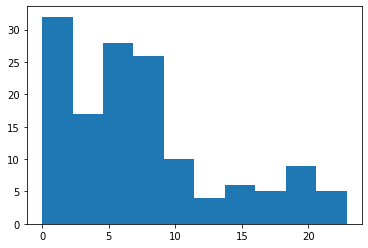

In [74]:
plt.hist(wait_times)

In [76]:
np.min(customer_queue.lengths)

0

In [77]:
np.max(customer_queue.lengths)

8

In [78]:
np.mean(customer_queue.lengths)

2.7559322033898304